In [6]:
!pip install google-search-results cohere pandas numpy sklearn matplotlib ntlk

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk
Note: you may need to restart the kernel to use updated packages.


In [1]:
from serpapi import GoogleSearch
import cohere
from cohere.responses.classify import Example
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
from collections import Counter
import sklearn

In [2]:
cohere_key = 'Wn8Ud7xYLgyAG3AjAJD1UjoWeSSW2PByZkgGfeSQ'
place_id = "gyubee-japanese-grill-dundas-toronto"
serp_key = "e268253d605841ad91dc5ccf11061b9f5cf73820cde81000133f17fb8f956125"
co = cohere.Client(cohere_key)
params = {
  "engine": "yelp_reviews",
  "place_id": place_id,
  "api_key": serp_key,
}

In [3]:
training_data = pd.read_csv('a1_restaurantReviews_HistoricDump.csv')

In [4]:
mapping = {0: "Negative", 1: "Positive"}  
training_data["Liked"] = training_data["Liked"].replace(mapping)
#append the data to an examples
examples = []
for index, row in training_data.iterrows():
    example = Example(row["Review"], row["Liked"])
    examples.append(example)
print(training_data)

                                                Review     Liked
0                             Wow... Loved this place.  Positive
1                                   Crust is not good.  Negative
2            Not tasty and the texture was just nasty.  Negative
3    Stopped by during the late May bank holiday of...  Positive
4    The selection on the menu was great and so wer...  Positive
..                                                 ...       ...
895  I want to first say our server was great and w...  Positive
896                     The pizza selections are good.  Positive
897              I had strawberry tea, which was good.  Positive
898  Highly unprofessional and rude to a loyal patron!  Negative
899                       Overall, a great experience.  Positive

[900 rows x 2 columns]


In [5]:
#search for the reviews (serp api)
search = GoogleSearch(params)
results = search.get_dict()
reviews = results["reviews"]
#append the review to review array
reviews_array = []
for user_data in reviews:
    comment_text = user_data['comment']['text']
    reviews_array.append(comment_text)



In [6]:
response_1 = co.classify(
  inputs=reviews_array,
  examples=examples,
)

reviews_dict = {"text": [], "sentiment": [], "confidence": []}
for data in response_1.classifications:
    text = data.input
    sentiment = data.prediction
    confidence = data.confidence*100
    review_dict = {"text": text, "sentiment": sentiment, "confidence": confidence}
    reviews_dict["text"].append(text)
    reviews_dict["sentiment"].append(sentiment)
    reviews_dict["confidence"].append(confidence)
    

    
    
reviews_sentiment_df = pd.DataFrame(reviews_dict)
print(reviews_sentiment_df)

                                                text sentiment  confidence
0  Great food and it has good quality meat! Def r...  Positive   99.995230
1  Good service and kind servers.And i prefer to ...  Positive   99.999917
2  Great food but make sure you have so much pati...  Positive   99.957925
3  It was my first time visiting this location- I...  Positive   86.312264
4  On a Friday night, I joined the Yelp waitlist ...  Negative   97.594005
5  If you aren't on the waitlist on Yelp, don't e...  Negative   99.623290
6  From my first time here, I can say everything ...  Positive   99.999870
7  Gyubee is always consistently good! This locat...  Negative   55.094400
8  Great Japanese BBQ in Toronto! Gyubee is a pre...  Positive   52.112210
9  Another unique dining experience coming up soo...  Positive   99.998850


In [7]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

# Define a function to extract adjectives and nouns from a text
def extract_adj_noun(text):
    tokens = word_tokenize(text.lower())
    pos_tags = pos_tag(tokens)
    adj_noun = [word for word, tag in pos_tags if tag in ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']]
    return ' '.join(adj_noun)

# Apply the function to the review text column
reviews_sentiment_df['adj_noun'] = reviews_sentiment_df['text'].apply(extract_adj_noun)
print(reviews_sentiment_df)

                                                text sentiment  confidence  \
0  Great food and it has good quality meat! Def r...  Positive   99.995230   
1  Good service and kind servers.And i prefer to ...  Positive   99.999917   
2  Great food but make sure you have so much pati...  Positive   99.957925   
3  It was my first time visiting this location- I...  Positive   86.312264   
4  On a Friday night, I joined the Yelp waitlist ...  Negative   97.594005   
5  If you aren't on the waitlist on Yelp, don't e...  Negative   99.623290   
6  From my first time here, I can say everything ...  Positive   99.999870   
7  Gyubee is always consistently good! This locat...  Negative   55.094400   
8  Great Japanese BBQ in Toronto! Gyubee is a pre...  Positive   52.112210   
9  Another unique dining experience coming up soo...  Positive   99.998850   

                                            adj_noun  
0  great food good quality meat def recommend sal...  
1  good service kind servers.an

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object and fit it to the adj_noun column
vectorizer = CountVectorizer()
vectorizer.fit(reviews_sentiment_df['adj_noun'])

# Transform the adj_noun column into a sparse matrix of term frequencies
vector = vectorizer.transform(reviews_sentiment_df['adj_noun'])

# Print the matrix
print(vector)

  (0, 50)	1
  (0, 84)	1
  (0, 92)	2
  (0, 93)	2
  (0, 111)	1
  (0, 128)	1
  (0, 135)	1
  (0, 150)	1
  (0, 173)	1
  (0, 188)	1
  (0, 192)	1
  (0, 198)	1
  (0, 208)	1
  (0, 264)	1
  (1, 9)	1
  (1, 23)	1
  (1, 38)	1
  (1, 51)	1
  (1, 92)	1
  (1, 113)	2
  (1, 154)	1
  (1, 165)	1
  (1, 199)	1
  (1, 207)	1
  (1, 208)	1
  :	:
  (9, 79)	1
  (9, 84)	1
  (9, 85)	1
  (9, 90)	2
  (9, 92)	1
  (9, 94)	1
  (9, 100)	1
  (9, 103)	1
  (9, 107)	1
  (9, 131)	1
  (9, 140)	1
  (9, 148)	1
  (9, 152)	2
  (9, 163)	1
  (9, 183)	1
  (9, 191)	1
  (9, 200)	1
  (9, 202)	1
  (9, 211)	1
  (9, 215)	1
  (9, 240)	2
  (9, 249)	1
  (9, 254)	1
  (9, 258)	1
  (9, 276)	1


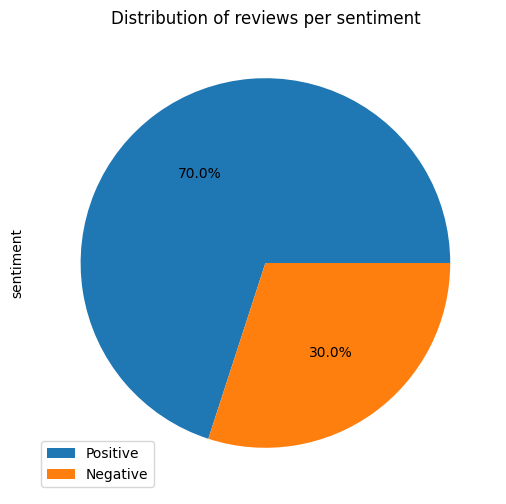

In [9]:
reviews_sentiment_df['sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

4    Negative
2    Positive
1    Positive
0    Positive
5    Negative
6    Positive
3    Positive
9    Positive
Name: sentiment, dtype: object


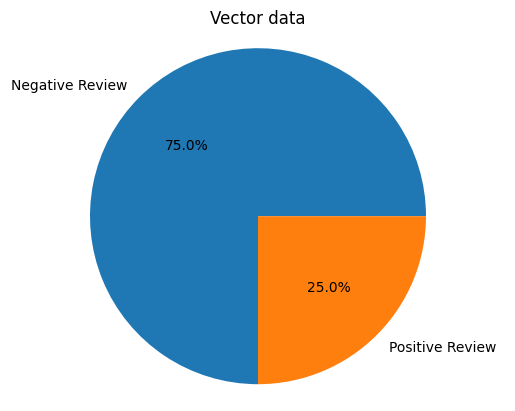

In [10]:
from sklearn.model_selection import train_test_split
X = reviews_sentiment_df['text']
y = reviews_sentiment_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(vector,y,test_size = 0.2)

print(y_train)
plt.pie(y_train.value_counts(), 
        labels=['Negative Review','Positive Review'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title("Vector data")
plt.show()

In [18]:
bad_reviews = []
good_reviews = []

for data in response_1.classifications:
  if float(data.confidence) > 0.6:
    if data.prediction == "Positive":
      good_reviews.append(data.input)
    if data.prediction == "Negative":
      bad_reviews.append(data.input)

#join the string
bad_reviews_string = " ".join(bad_reviews)
good_reviews_string = " ".join(good_reviews)
#this is for the reviews  
text=(
  bad_reviews_string
)
#what most of the good/bad repsonse talk about 
response_2 = co.summarize(
  text=text,
  length="short",
  extractiveness="high",
  format="bullets",
  additional_command="give only keywords"
)

prompt1 = "get key words from the text: " + bad_reviews_string
prompt2 = "get key words from the text: " + good_reviews_string
# model = co.topic_modeling(good_reviews)
# print(model.topics)
advice1 = co.generate(
    model='command-nightly',  
    prompt = prompt1,  
    max_tokens=200,  
    temperature=0.750)
advice2 = co.generate(
    model='command-nightly',  
    prompt = prompt2,  
    max_tokens=200,  
    temperature=0.750)
print("Bad reviews keywords\n")
print(advice1.generations[0])
print("\n")
print("Good reviews keywords\n")
print(advice2.generations[0])

Bad reviews keywords


waitlist, Yelp, table, dinner, restaurant, Gyubee, beef, pork belly, lamb, prime kalbi, king oyster mushroom, salmon, bibimbap, cold noodles, crème brûlée, Melona, service, grill, top up, dessert, popsicle, strawberry, mango, Yelp, time, patrons, venue, floor, dining, time, food, service


Good reviews keywords


Great service and good vibes, no loud music so you can chat easily, kind servers, delicious cold noodle and bibimbab, good quality meat, great food, make sure you have so much patience because the reservation here will make you wait for about an hour before you eat.


In [12]:
!pip install imblearn

In [13]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [14]:
# create logistic regression model + SMOTE
logreg = LogisticRegression()
# train model on  vectorised training data
model = logreg.fit(X_train, y_train)

In [15]:
import shap

explainer = shap.Explainer(model, X_train, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

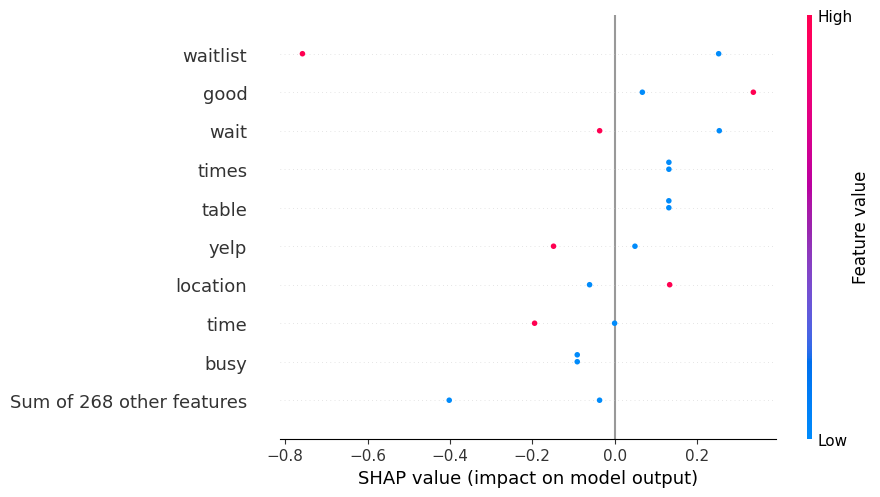

In [17]:
shap.plots.beeswarm(shap_values,max_display=10)